# Data Collection & Preparation
**Objective:** Build dynamic cryptocurrency universe with proper eligibility handling

**Universe:** 9 liquid cryptocurrencies (BTC, ETH, BNB, XRP, ADA, SOL, DOGE, AVAX, DOT)  
**Period:** 2020-01-01 to 2026-02-01  
**Frequency:** Daily close prices

In [1]:
# Imports
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

client = bnb_client(tld='US')

In [2]:
# Helper function to format Binance data
def format_binance(data):
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
               'quote_volume', 'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    
    df = pd.DataFrame(data, columns=columns)
    df['open_time'] = df['open_time'].map(lambda x: datetime.fromtimestamp(x/1000))
    df['close_time'] = df['close_time'].map(lambda x: datetime.fromtimestamp(x/1000))
    
    return df

In [3]:
# Define universe and pull data
universe = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT',
            'SOLUSDT', 'DOGEUSDT', 'AVAXUSDT', 'DOTUSDT']

freq = '1d'
start_date = '2020-01-01'

# Collect price data
px_dict = {}
for symbol in universe:
    data = client.get_historical_klines(symbol, freq, start_date)
    df = format_binance(data)
    px_dict[symbol] = df.set_index('open_time')['close'].astype(float)

# Combine into DataFrame
px = pd.DataFrame(px_dict)
px = px.sort_index()
px.columns = [col.replace('USDT', '') for col in px.columns]

print(f"Collected {px.shape[0]} days × {px.shape[1]} coins")
print(f"Period: {px.index[0].date()} to {px.index[-1].date()}")

Collected 2227 days × 9 coins
Period: 2019-12-31 to 2026-02-03


In [4]:
# Calculate returns
ret = px / px.shift(1) - 1

print(f"\nReturns calculated: {ret.shape}")


Returns calculated: (2227, 9)


In [5]:
# Create eligibility mask (dynamic universe)
# Coins eligible when they have 60+ days of valid price history

min_hist = 60

# Count valid observations
hist = px.notna().cumsum()

# Eligible if had min_hist observations through yesterday
elig = hist.shift(1) >= min_hist
elig = elig & ret.notna()

print(f"Eligibility mask created (min_hist={min_hist} days)")
print(f"Average coins eligible per day: {elig.sum(axis=1).mean():.1f}")

Eligibility mask created (min_hist=60 days)
Average coins eligible per day: 7.6


In [6]:
# Data quality summary
print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)

print(f"\nPeriod: {px.index[0].date()} to {px.index[-1].date()}")
print(f"Total days: {len(px)}")
print(f"Coins: {len(px.columns)}")
print(f"\nEligible coin-days: {elig.sum().sum()}")
print(f"Average coins per day: {elig.sum(axis=1).mean():.1f}")

print("\nAnnualized returns (%):") 
print((ret.mean() * 365 * 100).round(1))


DATA SUMMARY

Period: 2019-12-31 to 2026-02-03
Total days: 2227
Coins: 9

Eligible coin-days: 16942
Average coins per day: 7.6

Annualized returns (%):
BTC      57.9
ETH      81.3
BNB     101.8
XRP      76.3
ADA      87.0
SOL     130.6
DOGE    176.8
AVAX     -8.1
DOT     -41.0
dtype: float64


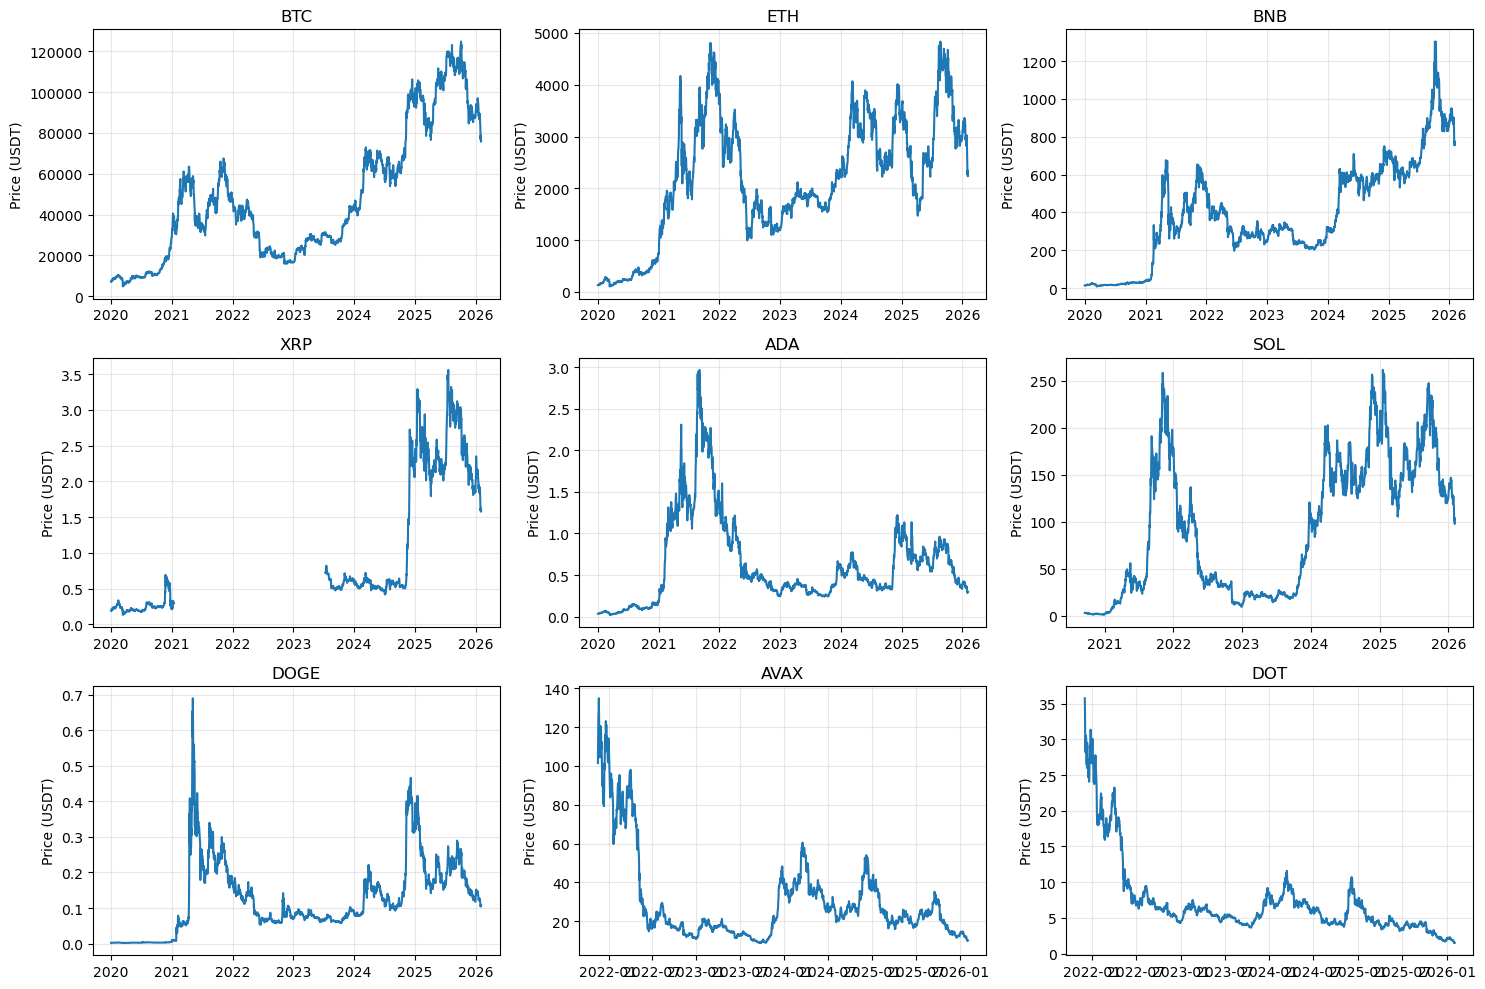

Price chart saved as 'price_evolution.png'


In [7]:
# Visualize price evolution
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(px.columns):
    axes[i].plot(px.index, px[col])
    axes[i].set_title(col)
    axes[i].set_ylabel('Price (USDT)')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('price_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Price chart saved as 'price_evolution.png'")

In [8]:
# Save processed data
px.to_csv('data_px.csv')
ret.to_csv('data_ret.csv')
elig.to_csv('data_elig.csv')

print("\nData saved: data_px.csv, data_ret.csv, data_elig.csv")


Data saved: data_px.csv, data_ret.csv, data_elig.csv
